In [334]:
# Importación de librerías

import numpy as np
import pandas as pd
import sklearn.compose as Compose
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.feature_extraction.text import CountVectorizer


import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
import re


In [335]:
train_url = "https://raw.githubusercontent.com/Kekon130/ML_Practica2/main/train.csv"
df_train = pd.read_csv(train_url)

test_url = "https://raw.githubusercontent.com/Kekon130/ML_Practica2/main/test.csv"
df_test = pd.read_csv(test_url)
submission = df_test[['ID']].copy()
#pd.set_option('display.max_columns', None)
df_test

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,99246,4759,1,Edwardsz,45.0,169291865.0,Manager,57738.060,4881.505000,9.0,...,11.0,Bad,3916.47,22.899499,157.0,Yes,296.284136,53.821178,Low_spent_Medium_value_payments,71.427393
1,90071,2573,6,Stevenw,42.0,655780925.0,Scientist,19205.485,1828.457083,5.0,...,3.0,Good,372.06,24.585730,241.0,No,39.417086,19.311009,Low_spent_Small_value_payments,211.447299
2,64375,34237,2,Dalaly,32.0,55005463.0,Scientist,49768.710,4045.392500,7.0,...,11.0,Standard,1428.04,25.129810,168.0,Yes,225.693491,50.036548,Low_spent_Small_value_payments,198.465986
3,142441,47128,8,Lashx,24.0,958087164.0,Lawyer,62424.120,5010.010000,7.0,...,6.0,Standard,1958.36,27.004401,154.0,Yes,175.360317,55.101365,High_spent_Large_value_payments,472.761456
4,135010,21542,5,Toonkelz,22.0,862456731.0,Entrepreneur,128163.360,10648.280000,5.0,...,5.0,Good,1494.56,30.911401,222.0,No,281.792301,77.036872,Low_spent_Large_value_payments,536.997743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,126990,43904,1,Wayneo,42.0,448192628.0,Scientist,37760.220,3393.685000,3.0,...,3.0,Good,821.10,23.938159,194.0,No,88.485663,37.562828,High_spent_Medium_value_payments,426.575752
19996,128347,8248,2,Daria Sito-Sucicd,32.0,563291145.0,Mechanic,29818.780,2257.898333,4.0,...,4.0,Good,702.20,30.990148,376.0,No,45.977299,27.931177,High_spent_Small_value_payments,298.961882
19997,88941,19882,4,Laurend,43.0,451289406.0,Lawyer,34744.150,2784.345833,3.0,...,3.0,Good,219.59,36.911828,398.0,No,52.218894,67.741940,Low_spent_Medium_value_payments,336.382928
19998,89599,50969,2,Nickx,35.0,994774680.0,Media_Manager,60271.920,4782.660000,6.0,...,11.0,Bad,4546.95,32.122843,96.0,Yes,203.605795,36.776460,High_spent_Medium_value_payments,381.365614


In [116]:
df_train.columns

Index(['Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour',
       'Credit_Score'],
      dtype='object')

In [122]:
df_train.Credit_Mix.unique()

array(['Good', 'Bad', 'Standard'], dtype=object)

In [131]:
credit_score = df_train.Credit_Score
credit_score_ordinal = []
for row in credit_score:
  if row == "Poor":
    credit_score_ordinal.append(0)
  if row == "Standard":
    credit_score_ordinal.append(1)
  if row == "Good":
    credit_score_ordinal.append(2)

credit_mix = df_train.Credit_Mix
credit_mix_ordinal = []
for row in credit_mix:
  if row == "Bad":
    credit_mix_ordinal.append(0)
  if row == "Standard":
    credit_mix_ordinal.append(1)
  if row == "Good":
    credit_mix_ordinal.append(2)
df_train.Credit_Mix = credit_mix_ordinal

In [135]:
credit_score = df_train.Payment_Behaviour
credit_score_ordinal = []
for row in credit_score:
  if row == "Low_spent_Medium_value_payments":
    credit_score_ordinal.append(0)
  if row == "Low_spent_Small_value_payments":
    credit_score_ordinal.append(1)
  if row == "Low_spent_Large_value_payments":
    credit_score_ordinal.append(2)
  if row == "High_spent_Medium_value_payments":
    credit_score_ordinal.append(3)
  if row == "High_spent_Small_value_payments":
    credit_score_ordinal.append(4)
  if row == "High_spent_Large_value_payments":
    credit_score_ordinal.append(5)
df_train.Payment_Behaviour = credit_score_ordinal

In [136]:
# Se incluyen: Credit mix
df_train.corr()

,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_History_Age,Payment_Behaviour,Credit_Score
Annual_Income,1.000000,-0.281876,-0.218327,-0.301307,-0.254974,-0.248730,-0.286552,-0.175673,-0.280101,0.342501,-0.267304,0.274049,0.248899,0.212140
Num_Bank_Accounts,-0.281876,1.000000,0.442708,0.583717,0.473781,0.559269,0.601690,0.334204,0.518113,-0.724096,0.506809,-0.484647,-0.077984,-0.386351
Num_Credit_Card,-0.218327,0.442708,1.000000,0.498413,0.418240,0.480885,0.424129,0.257656,0.459463,-0.545055,0.491301,-0.418541,-0.057244,-0.403647
Interest_Rate,-0.301307,0.583717,0.498413,1.000000,0.558328,0.588661,0.571920,0.371548,0.631146,-0.752571,0.629239,-0.576542,-0.083962,-0.484015
Num_of_Loan,-0.254974,0.473781,0.418240,0.558328,1.000000,0.501312,0.473610,0.375606,0.564324,-0.636945,0.638042,-0.605599,-0.073127,-0.355965
Delay_from_due_date,-0.248730,0.559269,0.480885,0.588661,0.501312,1.000000,0.540739,0.299054,0.539086,-0.689341,0.572628,-0.491401,-0.070646,-0.429844
Num_of_Delayed_Payment,-0.286552,0.601690,0.424129,0.571920,0.473610,0.540739,1.000000,0.331552,0.499949,-0.758182,0.504207,-0.481859,-0.076142,-0.371299
Changed_Credit_Limit,-0.175673,0.334204,0.257656,0.371548,0.375606,0.299054,0.331552,1.000000,0.383502,-0.433995,0.465318,-0.428852,-0.041003,-0.170701
Num_Credit_Inquiries,-0.280101,0.518113,0.459463,0.631146,0.564324,0.539086,0.499949,0.383502,1.000000,-0.662422,0.595353,-0.609310,-0.080260,-0.434142
Credit_Mix,0.342501,-0.724096,-0.545055,-0.752571,-0.636945,-0.689341,-0.758182,-0.433995,-0.662422,1.000000,-0.687270,0.640469,0.089606,0.497059



## Analizando las columnas

In [ ]:
# Customer ID. 
# Esta se deja tal cual y no se toca, la necesitamos

In [ ]:
def transformar_valores(columna, decimal):
  for index, row in df_train.iterrows():
    df_train.loc[index, columna] = round(df_train.loc[index, columna], decimal)
    
'''
transformar_valores("Annual_Income", -4)
transformar_valores("Monthly_Inhand_Salary", -3)
transformar_valores("Changed_Credit_Limit", -1)
transformar_valores("Outstanding_Debt", -2)
transformar_valores("Credit_Utilization_Ratio", 1)
transformar_valores("Total_EMI_per_month", -1)
transformar_valores("Amount_invested_monthly", -1)
transformar_valores("Monthly_Balance", -2)
'''

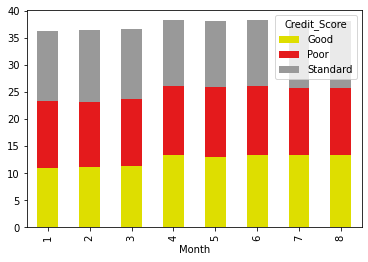

In [ ]:
# Month
# Representa el mes del año en el que se actualizó la información

# Podemos ver cómo el mes no influye casi nada, los valores están prácticamente igual repartidos 
plot = pd.crosstab(index=df_train['Month'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])


In [ ]:
# Name
# Esta variable la vamos a borrar, ya que tiene bastantes menos valores que el Customer_ID y ello puede dar problemas para el tratamiento posterior. Además no nos aporta nada.

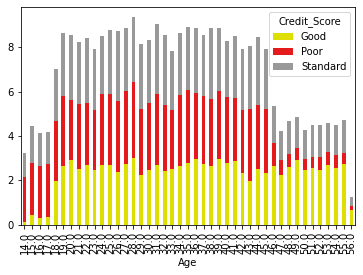

In [ ]:
# Age
# Edad -> Clasificar en tres grupos (va desde los 14 años hasta los 59)        juventud (14 - 26)           adultez (27 - 40)          otro (41 - 59)

# Vemos la realcion de edad con la bariable objetivosss

plot = pd.crosstab(index=df_train['Age'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])


# Malos: 17
# Estándar: 46
# Bueno: 

In [ ]:
# SNN
df_train.Customer_ID.nunique()
df_train.SSN.nunique()                                  # La seguridad social la vamos a borrar entonces

# Ambos devuelven tienen el mismo numero, vamos, que cada uno va ligado a un mismo cliente.

12500

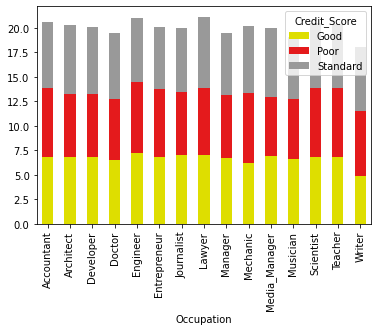

In [ ]:
# Occupation
output = pd.crosstab(df_train["Credit_Score"], df_train["Occupation"])
output

plot = pd.crosstab(index=df_train['Occupation'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# Es bastante estable en todos los campos 

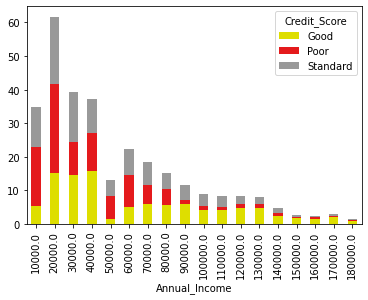

In [ ]:
plot = pd.crosstab(index=df_train['Annual_Income'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# Podemos observar cosas importantes y obvias, como quien tiene más dinero tiene un historial crediticio mejor y cómo el que gana menos lo tiene bastante peor. 
# A parte del tratamiento de resondear a los 10K no se me ocurre otro
# 0-50.000 50.000-90.000 90.000 - ...

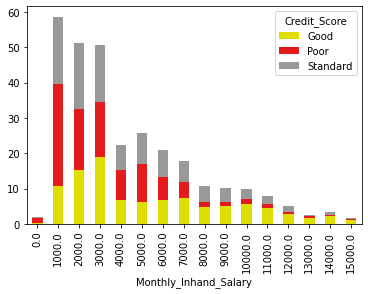

In [ ]:
# Monthly_Inhand_Salary
# Aquí haremos lo mismo que en los ingresos anuales, pero redonderaremos a 1000 
plot = pd.crosstab(index=df_train['Monthly_Inhand_Salary'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# Los resultados son muy similares al anterior
# 0-3 bajo 4-8 medio 8- ... mucho

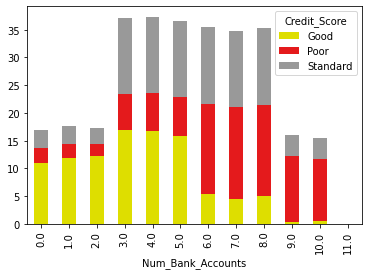

In [ ]:
# Num_Bank_Accounts

plot = pd.crosstab(index=df_train['Num_Bank_Accounts'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# Podemos observar que hay una relación super alta entre tener más bancarias y un Credit_Score peor. Los valores se distribuyen uniformemente entre 0-2, 3-5, 6-8 y 9-10    (Por qué hay 0?)

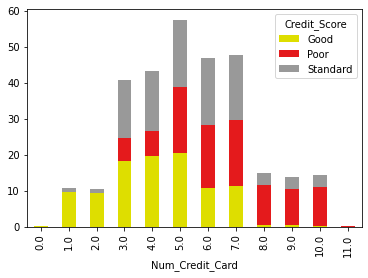

In [ ]:
# Num_Credit_Card

plot = pd.crosstab(index=df_train['Num_Credit_Card'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# La misma cosa, sólo que ahora se distribuye de otra forma, 0-2, 3-4, 5-7 y 8-10

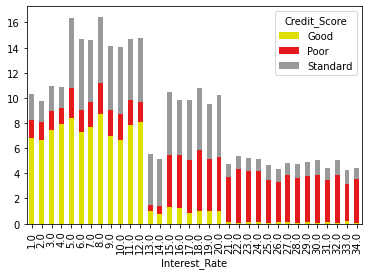

In [ ]:
# Interest_Rate

plot = pd.crosstab(index=df_train['Interest_Rate'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# Más interés, más pobre 5 grupos claros. 1-4 5-12 13-14 15-20 21-34

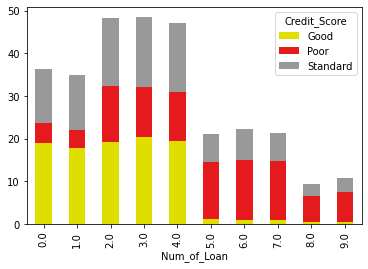

In [ ]:
# Num_of_Loan
plot = pd.crosstab(index=df_train['Num_of_Loan'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# Más préstamos activos, más pobre. En este caso está repartido más o menos en grupos 0-1, 2-4 y 5-9

In [ ]:
# Type_of_Loan

# Ayuda por favor

# Ya haré esto

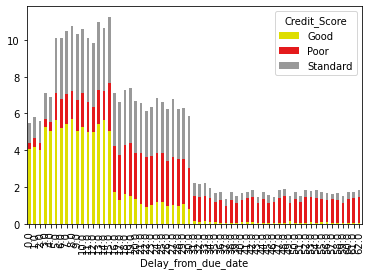

In [ ]:
# Delay_from_due_date
# Número medio de días de retraso en el pago

plot = pd.crosstab(index=df_train['Delay_from_due_date'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])
                          
# Bastante claro, está separado en unos 4 grupos
# Dividir en meses

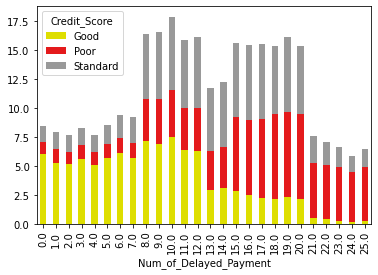

In [ ]:
# Num_of_Delayed_Payment
# Número medio de pagos atrasados del cliente

plot = pd.crosstab(index=df_train['Num_of_Delayed_Payment'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# Como siempre, 4 grupos, 0-7, 8-14, 15-20, 21-25

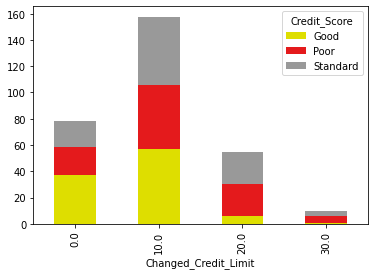

In [ ]:
# Changed_Credit_Limit
# Porcentaje de cambio en los límites de gasto del cliente..    No sé qué es esto
plot = pd.crosstab(index=df_train['Changed_Credit_Limit'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# No varía mucho, pero se ve que a menos porcentaje más bueno

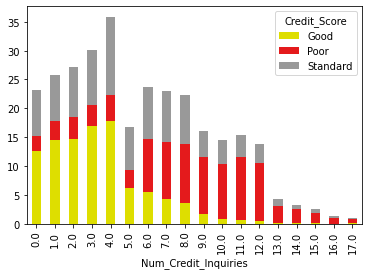

In [ ]:
# Num_Credit_Inquiries
# Número de consultas sobre tarjetas de crédito realizadas por el cliente.

plot = pd.crosstab(index=df_train['Num_Credit_Inquiries'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# No sé qué es esto de consultas, pero a menos consultas, mejor es el resultado

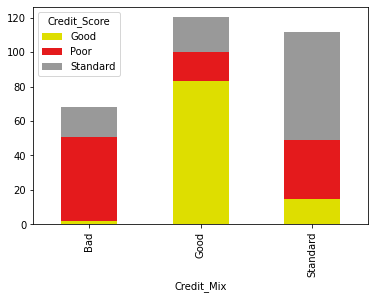

In [ ]:
# Credit_Mix

plot = pd.crosstab(index=df_train['Credit_Mix'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# Good es más good, etc, obvio.

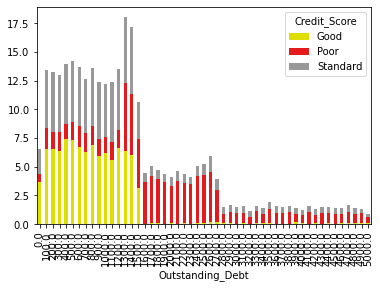

In [ ]:
# Outstanding_Debt
# Deuda en dólares
plot = pd.crosstab(index=df_train['Outstanding_Debt'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# A partir de la deuda de 1600 dólares, todos tienen un resultado muy pobre

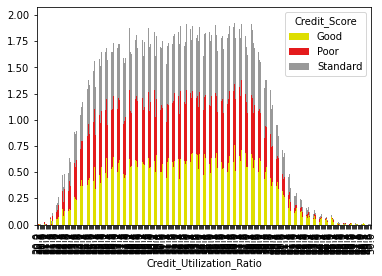

In [ ]:
# Credit_Utilization_Ratio

plot = pd.crosstab(index=df_train['Credit_Utilization_Ratio'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])


# No veo, ya lo veré en mejor detalle

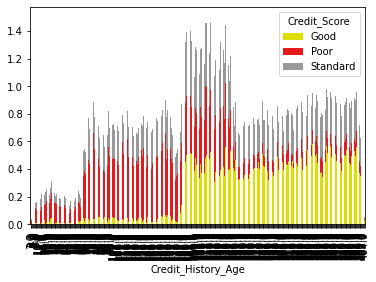

In [ ]:
# Credit_History_Age
# Antigüedad del historial de crédito.

plot = pd.crosstab(index=df_train['Credit_History_Age'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# Antes del 202 muy pobre, después de un número que no alcanzo a ver es mejor

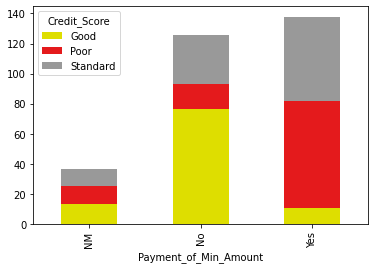

In [ ]:
# Payment_of_Min_Amount
# Representa si la persona sólo ha pagado el importe mínimo.

plot = pd.crosstab(index=df_train['Payment_of_Min_Amount'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# Obvio                      

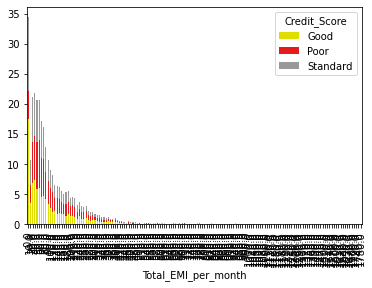

In [ ]:
# Total_EMI_per_month
plot = pd.crosstab(index=df_train['Total_EMI_per_month'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# ESTA TABLA NO ES, TENGO QUE VOLVER A HACERLA

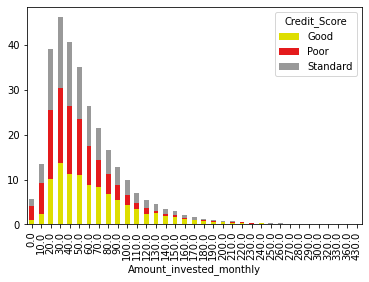

In [ ]:
# Amount_invested_monthly
plot = pd.crosstab(index=df_train['Amount_invested_monthly'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# Menos invertido, más pobre

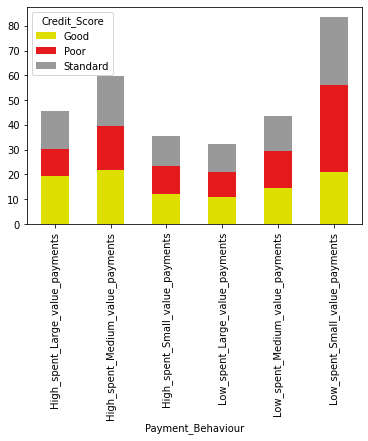

In [ ]:
# Payment_Behaviour

plot = pd.crosstab(index=df_train['Payment_Behaviour'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])

# Ya se ve, esta habría que ponerla en OneHotEncoder

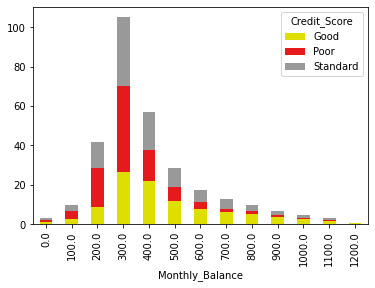

In [ ]:
# Monthly_Balance
plot = pd.crosstab(index=df_train['Monthly_Balance'],
            columns=df_train["Credit_Score"]
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True, color=['#dede00', '#e41a1c', '#999999'])


# Cuanto más alto, mejor es

## Pre procesamiento

In [336]:
# Columnas innecesarias a simple vista
df_train = df_train.drop('Month', axis=1)
df_train = df_train.drop('Name', axis=1)
df_train = df_train.drop('SSN', axis=1)
df_train = df_train.drop('Occupation', axis=1)
df_train = df_train.drop('ID', axis=1)
df_train = df_train.drop('Customer_ID', axis=1)

In [337]:
# Columnas innecesarias después de analizar la tabla de correlaciones
df_train = df_train.drop('Credit_Utilization_Ratio', axis=1)
df_train = df_train.drop('Total_EMI_per_month', axis=1)
df_train = df_train.drop('Amount_invested_monthly', axis=1)
#df_train = df_train.drop('Payment_Behaviour', axis=1)            # empeora un 0.002 con esto :(
df_train = df_train.drop('Monthly_Balance', axis=1)
df_train = df_train.drop('Monthly_Inhand_Salary', axis=1)
df_train = df_train.drop('Age', axis=1)
#df_train = df_train.drop('Type_of_Loan', axis=1)
df_train = df_train.drop('Outstanding_Debt', axis=1)


y = df_train['Credit_Score']


df_train = df_train.drop('Credit_Score', axis=1)



In [338]:
# Procesamiento de la columna TypeOfLoan
count_vectorizer = CountVectorizer(tokenizer = lambda x: re.sub(", ", ",", x).replace("and ", "").split(',')) 
data = count_vectorizer.fit_transform(df_train['Type_of_Loan'])
print(count_vectorizer.get_feature_names_out())

data_array = data.toarray()
data_array[data_array > 1] = 1

df_train[count_vectorizer.get_feature_names_out()] = data_array

df_train = df_train.drop('Type_of_Loan', axis=1)

['auto loan' 'credit-builder loan' 'debt consolidation loan'
 'home equity loan' 'mortgage loan' 'no data' 'not specified'
 'payday loan' 'personal loan' 'student loan']


In [339]:
# Discretización de variables
dos_categorias = ["Bajo", "Alto"]
tres_categorias = ["Bajo", "Medio", "Alto"]
cuatro_categorias = ["Bajo", "Medio", "Alto", "Muy alto"]
cinco_categorias = ["Muy bajo", "Bajo", "Medio", "Alto", "Muy alto"]

'''
valores = [-math.inf, 50000, 90000, math.inf]
df_train["Annual_Income"] = pd.cut(x=df_train["Annual_Income"], bins=valores, labels=tres_categorias)

valores = [-math.inf, 3000, 7000, math.inf]
df_train["Monthly_Inhand_Salary"] = pd.cut(x=df_train["Monthly_Inhand_Salary"], bins=valores, labels=tres_categorias)

valores = [-math.inf, 4, 12, 14, 20, math.inf]
df_train["Interest_Rate"] = pd.cut(x=df_train["Interest_Rate"], bins=valores, labels=cinco_categorias)

valores = [-math.inf, 4, 15, 30, math.inf]
df_train["Delay_from_due_date"] = pd.cut(x=df_train["Delay_from_due_date"], bins=valores, labels=cuatro_categorias)

valores = [-math.inf, 10, 20, 30, math.inf]
df_train["Changed_Credit_Limit"] = pd.cut(x=df_train["Changed_Credit_Limit"], bins=valores, labels=cuatro_categorias)

valores = [-math.inf, 4, 12, math.inf]
df_train["Num_Credit_Inquiries"] = pd.cut(x=df_train["Num_Credit_Inquiries"], bins=valores, labels=tres_categorias)

valores = [-math.inf, 15, 22, math.inf]
df_train["Outstanding_Debt"] = pd.cut(x=df_train["Outstanding_Debt"], bins=valores, labels=tres_categorias)

valores = [-math.inf, 17, 46, math.inf]
df_train["Age"] = pd.cut(x=df_train["Age"], bins=valores, labels=tres_categorias)
'''

valores = [-math.inf, 2, 5, 8, math.inf]
df_train["Num_Bank_Accounts"] = pd.cut(x=df_train["Num_Bank_Accounts"], bins=valores, labels=cuatro_categorias)

valores = [-math.inf, 2, 4, 7, math.inf]
df_train["Num_Credit_Card"] = pd.cut(x=df_train["Num_Credit_Card"], bins=valores, labels=cuatro_categorias)

valores = [-math.inf, 4, math.inf]
df_train["Num_of_Loan"] = pd.cut(x=df_train["Num_of_Loan"], bins=valores, labels=dos_categorias)

valores = [-math.inf, 7, 14, 20, math.inf]
df_train["Num_of_Delayed_Payment"] = pd.cut(x=df_train["Num_of_Delayed_Payment"], bins=valores, labels=cuatro_categorias)

In [340]:
oe = OrdinalEncoder()

#df_train[['Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Credit_Mix', 'Payment_Behaviour', 'Payment_of_Min_Amount']] = oe.fit_transform(df_train[['Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Credit_Mix', 'Payment_Behaviour', 'Payment_of_Min_Amount']])

'''
import pandas as pd
from sklearn import preprocessing

x = df_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_train = pd.DataFrame(x_scaled)'''

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

# get_dummies lo mejora MUY POCO, lo dejo de momento, de momento da nuestra mejor marca
df_train = pd.get_dummies(df_train)

df_train = normalize(df_train)

df_train

,Annual_Income,Interest_Rate,Delay_from_due_date,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_History_Age,auto loan,credit-builder loan,debt consolidation loan,home equity loan,...,Credit_Mix_Standard,Payment_of_Min_Amount_NM,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,0.522475,0.212121,0.322581,0.000678,0.176471,0.831266,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.140846,0.787879,0.483871,0.651289,0.352941,0.354839,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.133922,0.878788,0.790323,0.779851,0.588235,0.302730,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.035230,0.151515,0.096774,0.343962,0.470588,0.317618,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.319732,0.515152,0.435484,0.417910,0.529412,0.300248,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.582464,0.242424,0.112903,0.476934,0.176471,0.521092,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
79996,0.053257,0.606061,0.709677,0.287653,0.352941,0.240695,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
79997,0.129314,0.151515,0.370968,0.547829,0.411765,0.595533,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
79998,0.212604,0.727273,0.516129,0.046811,0.705882,0.208437,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Pre procesamiento test

In [341]:
# Columnas innecesarias
df_test = df_test.drop('Month', axis=1)
df_test = df_test.drop('Name', axis=1)
df_test = df_test.drop('SSN', axis=1)
df_test = df_test.drop('Occupation', axis=1)
df_test = df_test.drop('ID', axis=1)
df_test = df_test.drop('Customer_ID', axis=1)

In [342]:
# Columnas innecesarias después de analizar la tabla de correlaciones
df_test = df_test.drop('Credit_Utilization_Ratio', axis=1)
df_test = df_test.drop('Total_EMI_per_month', axis=1)
df_test = df_test.drop('Amount_invested_monthly', axis=1)
#df_test = df_test.drop('Payment_Behaviour', axis=1)
df_test = df_test.drop('Monthly_Balance', axis=1)
df_test = df_test.drop('Monthly_Inhand_Salary', axis=1)
#df_test = df_test.drop('Type_of_Loan', axis=1)
df_test = df_test.drop('Age', axis=1)
df_test = df_test.drop('Outstanding_Debt', axis=1)


In [343]:
# Procesamiento de la columna TypeOfLoan
count_vectorizer = CountVectorizer(tokenizer = lambda x: re.sub(", ", ",", x).replace("and ", "").split(',')) 
data = count_vectorizer.fit_transform(df_test['Type_of_Loan'])
print(count_vectorizer.get_feature_names_out())

data_array = data.toarray()
data_array[data_array > 1] = 1

df_test[count_vectorizer.get_feature_names_out()] = data_array

df_test = df_test.drop('Type_of_Loan', axis=1)

['auto loan' 'credit-builder loan' 'debt consolidation loan'
 'home equity loan' 'mortgage loan' 'no data' 'not specified'
 'payday loan' 'personal loan' 'student loan']


In [344]:
dos_categorias = ["Bajo", "Alto"]
tres_categorias = ["Bajo", "Medio", "Alto"]
cuatro_categorias = ["Bajo", "Medio", "Alto", "Muy alto"]
cinco_categorias = ["Muy bajo", "Bajo", "Medio", "Alto", "Muy alto"]

'''
valores = [-math.inf, 50000, 90000, math.inf]
df_train["Annual_Income"] = pd.cut(x=df_train["Annual_Income"], bins=valores, labels=tres_categorias)

valores = [-math.inf, 3000, 7000, math.inf]
df_train["Monthly_Inhand_Salary"] = pd.cut(x=df_train["Monthly_Inhand_Salary"], bins=valores, labels=tres_categorias)

valores = [-math.inf, 4, 12, 14, 20, math.inf]
df_train["Interest_Rate"] = pd.cut(x=df_train["Interest_Rate"], bins=valores, labels=cinco_categorias)

valores = [-math.inf, 4, 15, 30, math.inf]
df_train["Delay_from_due_date"] = pd.cut(x=df_train["Delay_from_due_date"], bins=valores, labels=cuatro_categorias)

valores = [-math.inf, 10, 20, 30, math.inf]
df_train["Changed_Credit_Limit"] = pd.cut(x=df_train["Changed_Credit_Limit"], bins=valores, labels=cuatro_categorias)

valores = [-math.inf, 4, 12, math.inf]
df_train["Num_Credit_Inquiries"] = pd.cut(x=df_train["Num_Credit_Inquiries"], bins=valores, labels=tres_categorias)

valores = [-math.inf, 15, 22, math.inf]
df_train["Outstanding_Debt"] = pd.cut(x=df_train["Outstanding_Debt"], bins=valores, labels=tres_categorias)

valores = [-math.inf, 17, 46, math.inf]
df_test["Age"] = pd.cut(x=df_test["Age"], bins=valores, labels=tres_categorias)
'''

valores = [-math.inf, 2, 5, 8, math.inf]
df_test["Num_Bank_Accounts"] = pd.cut(x=df_test["Num_Bank_Accounts"], bins=valores, labels=cuatro_categorias)

valores = [-math.inf, 2, 4, 7, math.inf]
df_test["Num_Credit_Card"] = pd.cut(x=df_test["Num_Credit_Card"], bins=valores, labels=cuatro_categorias)

valores = [-math.inf, 4, math.inf]
df_test["Num_of_Loan"] = pd.cut(x=df_test["Num_of_Loan"], bins=valores, labels=dos_categorias)

valores = [-math.inf, 7, 14, 20, math.inf]
df_test["Num_of_Delayed_Payment"] = pd.cut(x=df_test["Num_of_Delayed_Payment"], bins=valores, labels=cuatro_categorias)

In [345]:
oe = OrdinalEncoder()

#df_test[['Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Credit_Mix', 'Payment_Behaviour', 'Payment_of_Min_Amount']] = oe.fit_transform(df_test[['Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Credit_Mix', 'Payment_Behaviour', 'Payment_of_Min_Amount']])
df_test = pd.get_dummies(df_test)

df_test = normalize(df_test)

df_test

,Annual_Income,Interest_Rate,Delay_from_due_date,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_History_Age,auto loan,credit-builder loan,debt consolidation loan,home equity loan,...,Credit_Mix_Standard,Payment_of_Min_Amount_NM,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,0.293281,0.878788,0.983871,0.670624,0.647059,0.387097,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.070525,0.000000,0.016129,0.356513,0.176471,0.595533,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.247210,0.515152,0.403226,0.094980,0.647059,0.414392,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.320371,0.848485,0.903226,0.647218,0.352941,0.379653,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.700407,0.181818,0.225806,0.281208,0.294118,0.548387,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.177790,0.060606,0.016129,0.376526,0.176471,0.478908,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19996,0.131880,0.181818,0.080645,0.186228,0.235294,0.930521,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19997,0.160354,0.060606,0.016129,0.067164,0.176471,0.985112,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19998,0.307929,0.787879,0.483871,0.961669,0.647059,0.235732,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


## Entrenamiento

In [346]:
credit_score = y
credit_score_ordinal = []
for row in credit_score:
  if row == "Poor":
    credit_score_ordinal.append(0)
  if row == "Standard":
    credit_score_ordinal.append(1)
  if row == "Good":
    credit_score_ordinal.append(2)
y = credit_score_ordinal

In [347]:
len(y)

80000

In [348]:
import xgboost
from sklearn.model_selection import train_test_split


X = df_train  #.iloc[:,:-1]
y = credit_score_ordinal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
'''
xgb = xgboost.XGBClassifier(
    max_depth=9,
    learning_rate=0.1,
    n_estimators=300, 500
    reg_alpha=1.1,
    colsample_bytree = 0.9, 
    subsample = 0.9,
    n_jobs = 5,
    objective='multi:softmax',
    num_class=3,
    random_state=42
)'''

xgb = xgboost.XGBClassifier(
    max_depth=9,
    learning_rate=0.1,
    n_estimators=300,
    reg_alpha=1.1,
    colsample_bytree = 0.9, 
    subsample = 0.9,
    n_jobs = 5,
    objective='multi:softmax',
    num_class=3,
    random_state=42
)


'''
params = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'gamma': [0.01, 0.1]
}

gs2 = GridSearchCV(xgboost.XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')

gs2.fit(X_train, y_train) 

'''
xgb.fit(X_train, y_train) 

y_pred = xgb.predict(X_train)                         # train
y_pred_test = xgb.predict(X_test)
y_pred_dftest = xgb.predict(df_test)
#grid_search.best_estimator_
'''
print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)
'''

"\nprint('Best score:', gs2.best_score_)\nprint('Best score:', gs2.best_params_)\n"

In [ ]:
grid_search.best_estimator_

In [349]:
from sklearn.metrics import f1_score
print(f1_score(y_train, y_pred, average="macro"))               # train
print(f1_score(y_test, y_pred_test, average="macro"))               # test

0.9256871676649819
0.7774667154607192


## Random Forest (NO)

In [85]:
#Importing Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# https://medium.com/analytics-vidhya/random-forest-classifier-and-its-hyperparameters-8467bec755f6

X = df_train.iloc[:,:-1]

# Fitting Random Forest Classification to the Training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)


# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42, max_depth = 9, max_features = 10)
classifier.fit(X_train, y_train)

y_pred_train = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
y_pred_test = classifier.predict(df_test)

from sklearn.metrics import f1_score
print(f1_score(y_train, y_pred_train, average=None))
print(f1_score(y_test, y_pred, average=None))
# print(f"The score is: {f1}") 

[0.72653612 0.76910592 0.62250119]
[0.70596699 0.7515832  0.5990991 ]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
# Hyperparameter Tuning to improve Accuracy

# https://www.kaggle.com/code/akshaysharma001/naive-bayes-with-hyperpameter-tuning



from sklearn.naive_bayes import CategoricalNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
clf = CategoricalNB(alpha=0)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


IndexError: ignored

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


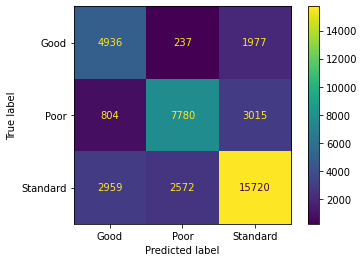

In [144]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

In [134]:
# Calculamos f1_score

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average=None)
print(f"The score is: {f1}") 

The score is: [0.62287842 0.70127997 0.74923147]


## Otros

In [350]:
submission['Credit_Score'] = y_pred_dftest

submission.to_csv("ML_GRUPO7.csv", index=False)

In [351]:
submission.Credit_Score = submission.Credit_Score.replace({0: "Poor", 1: "Standard", 2: "Good"})

In [352]:
from google.colab import files
submission.to_csv('submission_grupo7.csv', index=False) 
files.download('submission_grupo7.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Cosas Guarras (IGNORAR)

https://es.stackoverflow.com/questions/398654/como-ordenar-porcentajes-en-grafica-de-barras



Plot correlation in pandas

https://www.stackvidhya.com/plot-correlation-matrix-in-pandas-python/


Tablas y cosas chulas

https://relopezbriega.github.io/blog/2016/02/29/analisis-de-datos-categoricos-con-python/

In [ ]:
# GUARRADAS Y PRUEBAS GUARRAS

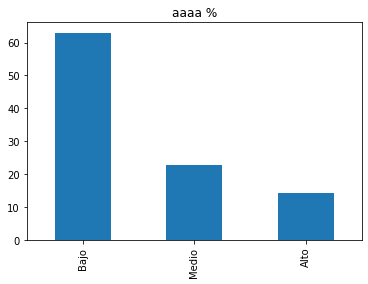

In [ ]:
# Month
# Representa el mes del año en el que se actualizó la información
# 
valores = [-math.inf, 50000, 90000, math.inf]
tres_categorias = ["Bajo", "Medio", "Alto"]

df_train["Annual_Income"] = pd.cut(x=df_train["Annual_Income"], bins=valores, labels=tres_categorias)

plot = (100 * df_train['Annual_Income'].value_counts() / len(df_train['Annual_Income'])).plot(
kind='bar', title='aaaa %')

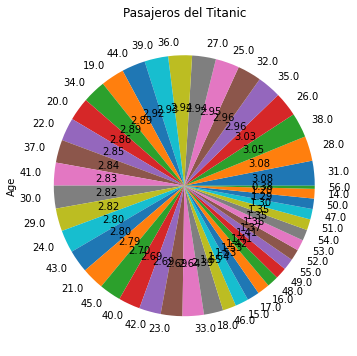

In [ ]:
plot = df_train['Age'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Pasajeros del Titanic')